# Lab 3 - Neural and neurosymbolic search

Note: I am running this on my personal laptop, which has an RTX3050 8GBs (I know, I know, it's an old laptop). Looking at Unsloth [requirements](https://docs.unsloth.ai/get-started/beginner-start-here/unsloth-requirements), I can fine-tune LLMs with 11B using QLoRA (4-bit) VRAM.

## Imports 

In [1]:
import re
import itertools
import math
import time
import random
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
from numpy.random import choice, randint
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Utilities for plotting
from symbolic_utilities import progress, compute_global_limits_smc, plot_mh_trace_upto, plot_state_2d
# MHMC sampler
from symbolic_utilities import propose_tree, get_coordinates, \
    mh_sampler, smc_sampler, define_bs_DSL, define_lt_DSL, enumerate_full_sentences

from neural_utilities import extract_xml_answer, extract_xml_reasoning, produce_tasks, get_data

from neural_utilities import print_func, lt_correctness_reward_func, \
    xmlcount_reward_func, soft_format_reward_func, strict_format_reward_func, cfg_reward_func, lt_correctness_reward_func, \
    direct_cfg_reward_func, direct_lt_correctness_reward_func

from symbolic_utilities import \
    ltgrammar, lt_nonterminals, lt_terminals, lt_eval_dict, \
    bsgrammar, bs_nonterminals, bs_terminals, bs_eval_dict

# NOTE: PatchFastRL needs to run **before** the imports below
from unsloth import FastLanguageModel, is_bfloat16_supported, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

import torch, gc
from datasets import load_dataset, Dataset
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments
from peft import AutoPeftModelForCausalLM
from trl import SFTTrainer, GRPOConfig, GRPOTrainer
from unsloth.chat_templates import get_chat_template
from vllm import SamplingParams

from dotenv import load_dotenv, find_dotenv
import os
from openai import OpenAI

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-04 21:24:26 __init__.py:190] Automatically detected platform cuda.


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

## Neural program synthesis I - binary strings domain

We are using the following libraries:
- Huggingface's Transformers 
- Unsloth: integrates with TRL and Transformers, can fine-tune LLMs using a variety of methods much faster than other libraries.
- vllm: Starts a server to do LLM stuff with, makes inference faster.
- trl: Reinforcement Learning fine-tuning

##  Neural program synthesis II - not-so-simple list transformation without reasoning

### Get the model

Let's start by getting one base model. I have chosen Qwen2.5-0.5B-Instruct, because I have an old laptop: 

In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.5, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    r=lora_rank, 
    # Which parts of the model are we gonna train?
    target_modules = [
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj",
        "gate_proj", 
        "up_proj", 
        "down_proj",
    ], 
    lora_alpha = lora_rank,
    # Enable long context finetuning
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 40.19%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 4.0 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.08 GB. Also swap space = 1 GB.
INFO 03-04 17:53:36 config.py:542] This model supports multiple tasks: {'generate', 'embed', 'classify', 'score', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes con

[W304 17:53:38.913132825 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-04 17:53:38 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-04 17:53:39 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-04 17:53:41 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 03-04 17:53:41 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-04 17:53:43 worker.py:267] Memory profiling takes 2.26 seconds
INFO 03-04 17:53:43 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 03-04 17:53:43 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 03-04 17:53:43 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 03-04 17:53:43 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 03-04 17:53:44 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occu

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]

INFO 03-04 17:53:58 model_runner.py:1562] Graph capturing finished in 14 secs, took 0.30 GiB
INFO 03-04 17:53:58 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 16.90 seconds



Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


### Starting with a simple prompt and a direct answer

In [4]:
lt_system_prompt = ""

In [5]:
# get 3000 sentences
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=5)):
    if i==5000:
        break
    sentences_pool.append(sent)

data = get_data(
    ltgrammar, 
    lt_system_prompt, 
    eval_dict=lt_eval_dict, 
    n_tasks=5000, 
    sentences_pool=sentences_pool
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Add the "completion" column to data:

In [6]:
data = data.map(lambda x: {
    'completion': [{'content': x['sentence'], 'role': 'assistant'}], 
})

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [7]:
data.to_pandas()

sentence  \
0           compose(map_(plus(4)),filter_(not_(gt(2))))   
1     compose(filter_(gt(5)),filter_(or_(gt(2),and_(...   
2     compose(map_(plus(5)),filter_(or_(not_(even),g...   
3     compose(map_(minus(2)),filter_(and_(gt(5),and_...   
4     compose(filter_(gt(3)),filter_(and_(not_(even)...   
...                                                 ...   
4995   compose(map_(times(4)),filter_(or_(even,gt(5))))   
4996  compose(filter_(not_(even)),filter_(not_(gt(4))))   
4997  compose(filter_(gt(5)),filter_(or_(and_(even,e...   
4998  compose(map_(minus(3)),filter_(and_(or_(even,e...   
4999  compose(filter_(not_(even)),filter_(or_(gt(3),...   

                                               examples  \
0      [[[0, 5, 6], []], [[9, 3, 7], []], [[0, 7], []]]   
1     [[[7, 8, 8, 7, 2], [7, 8, 8, 7]], [[2, 3], []]...   
2     [[[9, 5, 2], [14, 10, 7]], [[8, 4, 3], [13, 9,...   
3     [[[1, 3], []], [[1, 2, 5, 0], []], [[1, 7, 5, ...   
4     [[[6, 8], []], [[0, 9, 8, 2], [9]], [[2, 2, 0]...   
...                                                 ...   
4995  [[[2, 9], [8, 36]], [[1, 8, 8, 7, 6], [4, 32, ...   
4996  [[[7, 9, 3], [3]], [[4, 8, 6, 4, 8], []], [[2,...   
4997  [[[3, 5, 7, 7], []], [[4, 8, 7, 7], [8]], [[5,...   
4998  [[[5, 2, 1, 5, 8], []], [[3, 1], []], [[1, 6],...   
4999  [[[9, 5, 6, 6, 2], [9, 5]], [[6, 2, 6, 1, 5], ...   

                                                   task  \
0     -[0, 5, 6] -> []\n-[9, 3, 7] -> []\n-[0, 7] -> []   
1     -[7, 8, 8, 7, 2] -> [7, 8, 8, 7]\n-[2, 3] -> [...   
2     -[9, 5, 2] -> [14, 10, 7]\n-[8, 4, 3] -> [13, ...   
3     -[1, 3] -> []\n-[1, 2, 5, 0] -> []\n-[1, 7, 5,...   
4     -[6, 8] -> []\n-[0, 9, 8, 2] -> [9]\n-[2, 2, 0...   
...                                                 ...   
4995  -[2, 9] -> [8, 36]\n-[1, 8, 8, 7, 6] -> [4, 32...   
4996  -[7, 9, 3] -> [3]\n-[4, 8, 6, 4, 8] -> []\n-[2...   
4997  -[3, 5, 7, 7] -> []\n-[4, 8, 7, 7] -> [8]\n-[5...   
4998  -[5, 2, 1, 5, 8] -> []\n-[3, 1] -> []\n-[1, 6]...   
4999  -[9, 5, 6, 6, 2] -> [9, 5]\n-[6, 2, 6, 1, 5] -...   

                                                 prompt  \
0     [{'content': '', 'role': 'system'}, {'content'...   
1     [{'content': '', 'role': 'system'}, {'content'...   
2     [{'content': '', 'role': 'system'}, {'content'...   
3     [{'content': '', 'role': 'system'}, {'content'...   
4     [{'content': '', 'role': 'system'}, {'content'...   
...                                                 ...   
4995  [{'content': '', 'role': 'system'}, {'content'...   
4996  [{'content': '', 'role': 'system'}, {'content'...   
4997  [{'content': '', 'role': 'system'}, {'content'...   
4998  [{'content': '', 'role': 'system'}, {'content'...   
4999  [{'content': '', 'role': 'system'}, {'content'...   

                                             completion  \
0     [{'content': 'compose(map_(plus(4)),filter_(no...   
1     [{'content': 'compose(filter_(gt(5)),filter_(o...   
2     [{'content': 'compose(map_(plus(5)),filter_(or...   
3     [{'content': 'compose(map_(minus(2)),filter_(a...   
4     [{'content': 'compose(filter_(gt(3)),filter_(a...   
...                                                 ...   
4995  [{'content': 'compose(map_(times(4)),filter_(o...   
4996  [{'content': 'compose(filter_(not_(even)),filt...   
4997  [{'content': 'compose(filter_(gt(5)),filter_(o...   
4998  [{'content': 'compose(map_(minus(3)),filter_(a...   
4999  [{'content': 'compose(filter_(not_(even)),filt...   

                                           lt_terminals  
0     [compose, even, 1, 2, 3, plus, minus, ), and_,...  
1     [compose, even, 1, 2, 3, plus, minus, ), and_,...  
2     [compose, even, 1, 2, 3, plus, minus, ), and_,...  
3     [compose, even, 1, 2, 3, plus, minus, ), and_,...  
4     [compose, even, 1, 2, 3, plus, minus, ), and_,...  
...                                                 ...  
4995  [compose, even, 1, 2, 3, plus, minus, ), and_,...  
4996  [compose, even, 1, 2, 3, plus, m

In [8]:
a = data.to_pandas().iloc[120]

print(a.to_dict())
# for k,v in a.to_dict().items():
#     print(k, "\n")
#     print(v)
#     if isinstance(v, np.ndarray):
#         for x in v.tolist():
#             if isinstance(x, dict):
#                 print(x['content'])
#             else:
#                 print(x)
#     print('____')

{'sentence': 'compose(map_(plus(3)),filter_(and_(gt(2),or_(even,even))))', 'examples': array([array([array([0, 8, 6, 4]), array([], dtype=int64)], dtype=object),
       array([array([0, 6, 5]), array([8])], dtype=object),
       array([array([5, 5, 5, 8, 7]), array([ 8,  8,  8, 10])], dtype=object)],
      dtype=object), 'task': '-[0, 8, 6, 4] -> []\n-[0, 6, 5] -> [8]\n-[5, 5, 5, 8, 7] -> [8, 8, 8, 10]', 'prompt': array([{'content': '', 'role': 'system'},
       {'content': '-[0, 8, 6, 4] -> []\n-[0, 6, 5] -> [8]\n-[5, 5, 5, 8, 7] -> [8, 8, 8, 10]', 'role': 'user'}],
      dtype=object), 'completion': array([{'content': 'compose(map_(plus(3)),filter_(and_(gt(2),or_(even,even))))', 'role': 'assistant'}],
      dtype=object), 'lt_terminals': array(['compose', 'even', '1', '2', '3', 'plus', 'minus', ')', 'and_',
       ',', 'sort', 'map_', 'or_', '(', 'truncate', 'not_', 'gt', 'times',
       '5', 'filter_', '4', 'reverse'], dtype=object)}


In [12]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="lt_direct_output",
        seed=0,
        save_steps=40
    ),
)

trainer.train()

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

Packing train dataset (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 427 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 2
\        /    Total batch size = 16 | Total steps = 108
 "-____-"     Number of trainable parameters = 35,192,832


TrainOutput(global_step=108, training_loss=0.5693027843479757, metrics={'train_runtime': 904.0569, 'train_samples_per_second': 1.889, 'train_steps_per_second': 0.119, 'total_flos': 2531603292094464.0, 'train_loss': 0.5693027843479757})

At this point we have the model and the adapter which contains the lora weights.

In [13]:
model.save_lora('finetuned_lt')

And we can get the model with the lora adaptor we just trained:

In [9]:
%%capture
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "finetuned_lt",
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)

Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


Tranform datapoint d into the format expected by qwen models:

In [11]:
d = data.to_pandas().iloc[1]['prompt']

In [12]:
print(d)

[{'content': '', 'role': 'system'}
 {'content': '-[4, 7, 0, 4, 5] -> [4, 7, 4, 5]\n-[6, 5, 7] -> [6, 5, 7]\n-[0, 2] -> []', 'role': 'user'}]


In [14]:
inputs = tokenizer.apply_chat_template(
    d,  
    add_generation_prompt=False,
    tokenize=True,
    return_tensors="pt"
).to('cuda')

And now we get answers that look a lot closer to what we want, with generations roughly from our PCFG roughly enclosed in a \<reasoning\> block:

In [15]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs, 
    streamer=text_streamer, 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>system
<|im_end|>
<|im_start|>user
-[8, 7] -> [8, 7]
-[5, 3, 8, 3, 0] -> [8]
-[4, 3, 8, 6, 9] -> [8, 6, 9]<|im_end|>
<|im_start|>assistant
compose(filter_(gt(1)),filter_(or_(even,not_(even))))<|im_end|>


And now let's try the RL fine-tuning again, but on the distilled model. You can restart the kernel at this point and skip the steps above to define this model to make sure you're working with a clean GPU. We can get the model (it might make sense to restart the kernel before going foward and not import any previous model to make sure the GPU is empty):

In [19]:
from importlib import reload
import neural_utilities
reload(neural_utilities)
from neural_utilities import direct_cfg_reward_func, direct_lt_correctness_reward_func, is_in_lt_CFG

In [ ]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        direct_cfg_reward_func,
        direct_lt_correctness_reward_func
    ],
    args=GRPOConfig(
        # use vLLM for fast inference!
        use_vllm = True, 
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        # Increase to 4 for smoother training
        gradient_accumulation_steps = 1, 
        # Decrease if out of memory
        num_generations = 8, 
        max_prompt_length = 256,
        max_completion_length = 32,
        # Set to 1 for a full training run
        num_train_epochs = 1, 
        max_steps = 2500,
        save_steps = 50,
        max_grad_norm = 0.1,
        # Can use Weights & Biases
        report_to = "none", 
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data,
)
trainer.train()

Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 5,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
\        /    Total batch size = 8 | Total steps = 2,500
 "-____-"     Number of trainable parameters = 35,192,832


------------------------------ 
**Question**
-[3, 9] -> [8]
-[9, 8, 0] -> [8, 7]
-[6, 0] -> [5] 

**Response**
compose(map_(minus(1)),filter_(or_(gt(1),not_(even)))) 

**Extracted**
compose(map_(minus(1)),filter_(or_(gt(1),not_(even))))


Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),not_(even))))
[3, 9] --> [2, 8] vs [8]
Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),not_(even))))
[9, 8, 0] --> [8, 7, -1] vs [8, 7]
Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),not_(even))))
[6, 0] --> [5, -1] vs [5]
Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),gt(2))))
[3, 9] --> [2, 8] vs [8]
Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),gt(2))))
[9, 8, 0] --> [8, 7] vs [8, 7]
Prediction:  compose(map_(minus(1)),filter_(or_(gt(1),gt(2))))
[6, 0] --> [5] vs [5]
Prediction:  compose(map_(minus(1)),filter_(and_(gt(1),gt(3))))
[3, 9] --> [8] vs [8]
Prediction:  compose(map_(minus(1)),filter_(and_(gt(1),gt(3))))
[9, 8, 0] --> [8, 7] vs [8, 7]
Prediction:  compose(ma

------------------------------ 
**Question**
-[6, 0, 4, 5] -> [5, 4]
-[0, 7, 0, 8, 4] -> [6, 7]
-[0, 5] -> [4] 

**Response**
compose(map_(plus(2)),filter_(and_(not_(even),gt(4)))) 

**Extracted**
compose(map_(plus(2)),filter_(and_(not_(even),gt(4))))


Prediction:  compose(map_(plus(2)),filter_(and_(not_(even),gt(4))))
[6, 0, 4, 5] --> [7] vs [5, 4]
Prediction:  compose(map_(plus(2)),filter_(and_(not_(even),gt(4))))
[0, 7, 0, 8, 4] --> [9] vs [6, 7]
Prediction:  compose(map_(plus(2)),filter_(and_(not_(even),gt(4))))
[0, 5] --> [7] vs [4]
Prediction:  compose(map_(minus(1)),filter_(and_(gt(1),gt(2))))
[6, 0, 4, 5] --> [5, 3, 4] vs [5, 4]
Prediction:  compose(map_(minus(1)),filter_(and_(gt(1),gt(2))))
[0, 7, 0, 8, 4] --> [6, 7, 3] vs [6, 7]
Prediction:  compose(map_(minus(1)),filter_(and_(gt(1),gt(2))))
[0, 5] --> [4] vs [4]
Prediction:  compose(map_(minus(1)),filter_(or_(or_(even,even),gt(2))))
[6, 0, 4, 5] --> [5, 3, 4] vs [5, 4]
Prediction:  compose(map_(minus(1)),filter_(or_(or_(eve

/home/fausto/mambaforge/envs/arccourse/lib/python3.11/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 0f34a668-2de4-4b97-8fa5-9fedcdfca025)') - silently ignoring the lookup for the file config.json in unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit.
  warnings.warn(
/home/fausto/mambaforge/envs/arccourse/lib/python3.11/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit - will assume that the vocabulary was not modified.
  warnings.warn(


------------------------------ 
**Question**
-[9, 8, 9, 6, 1] -> [8, 6]
-[9, 0, 8, 0, 7] -> [8]
-[9, 8, 6] -> [8, 6] 

**Response**
compose(filter_(gt(3)),filter_(or_(or_(even,even),gt(3)))) 

**Extracted**
compose(filter_(gt(3)),filter_(or_(or_(even,even),gt(3))))


Prediction:  compose(filter_(gt(3)),filter_(or_(or_(even,even),gt(3))))
[9, 8, 9, 6, 1] --> [9, 8, 9, 6] vs [8, 6]
Prediction:  compose(filter_(gt(3)),filter_(or_(or_(even,even),gt(3))))
[9, 0, 8, 0, 7] --> [9, 8, 7] vs [8]
Prediction:  compose(filter_(gt(3)),filter_(or_(or_(even,even),gt(3))))
[9, 8, 6] --> [9, 8, 6] vs [8, 6]
Prediction:  compose(filter_(gt(3)),filter_(and_(or_(even,even),gt(1))))
[9, 8, 9, 6, 1] --> [8, 6] vs [8, 6]
Prediction:  compose(filter_(gt(3)),filter_(and_(or_(even,even),gt(1))))
[9, 0, 8, 0, 7] --> [8] vs [8]
Prediction:  compose(filter_(gt(3)),filter_(and_(or_(even,even),gt(1))))
[9, 8, 6] --> [8, 6] vs [8, 6]
Prediction:  compose(filter_(gt(3)),truncate(2))
[9, 8, 9, 6, 1] --> [9, 8] vs [8, 6

In [29]:
df_history = pd.DataFrame(trainer.state.log_history)

In [30]:
df_history

loss  grad_norm  learning_rate  rewards/print_func  \
0     0.1401   2.085959   2.000000e-08                 0.0   
1     0.1444   2.785249   4.000000e-08                 0.0   
2     0.1440   2.192275   6.000000e-08                 0.0   
3     0.1563   1.137886   8.000000e-08                 0.0   
4     0.1286   1.003197   1.000000e-07                 0.0   
...      ...        ...            ...                 ...   
2477  0.1789   3.332794   1.179386e-09                 0.0   
2478  0.1493   2.039561   1.074613e-09                 0.0   
2479  0.1566   0.090092   9.747124e-10                 0.0   
2480  0.1332   0.121992   8.796835e-10                 0.0   
2481  0.1530   2.863492   7.895268e-10                 0.0   

      rewards/direct_cfg_reward_func  \
0                                0.5   
1                                0.5   
2                                0.5   
3                                0.5   
4                                0.5   
...                              ...   
2477                             0.5   
2478                             0.5   
2479                             0.5   
2480                             0.5   
2481                             0.5   

      rewards/direct_lt_correctness_reward_func    reward  reward_std  \
0                                      2.291667  2.791667    0.602574   
1                                      1.750000  2.250000    1.080123   
2                                      1.270833  1.770833    1.240640   
3                                      2.562500  3.062500    0.363924   
4                                      2.708333  3.208333    0.547360   
...                                         ...       ...         ...   
2477                                   1.458333  1.958333    0.907421   
2478                                   2.750000  3.250000    0.707107   
2479                                   3.000000  3.500000    0.000000   
2480                                   2.000000  2.500000    0.000000   
2481                                   2.625000  3.125000    0.744024   

      completion_length        kl   epoch  step  
0                 20.25  3.502839  0.0002     1  
1                 20.50  3.609954  0.0004     2  
2                 21.50  3.599514  0.0006     3  
3                 20.25  3.907947  0.0008     4  
4                 20.00  3.214122  0.0010     5  
...                 ...       ...     ...   ...  
2477              15.75  4.472074  0.4956  2478  
2478              20.25  3.732619  0.4958  2479  
2479              20.00  3.913952  0.4960  2480  
2480              19.75  3.330460  0.4962  2481  
2481              20.00  3.825235  0.4964  2482  

[2482 rows x 12 columns]

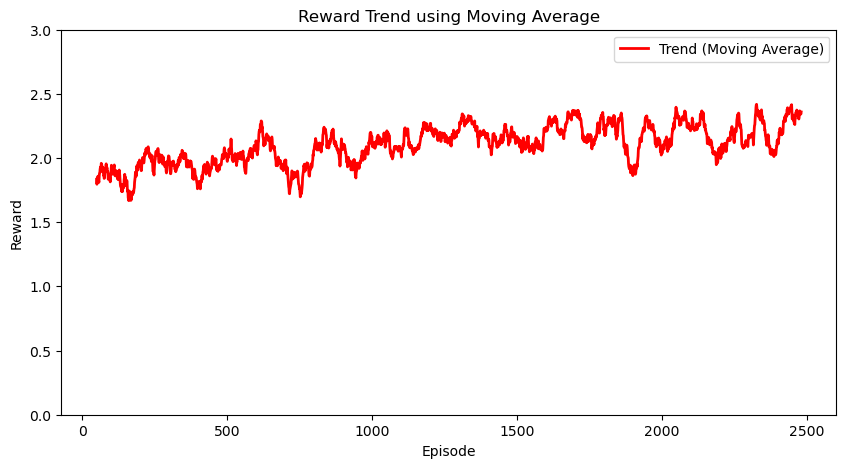

In [44]:
smoothed_rewards = df_history['rewards/direct_lt_correctness_reward_func'].rolling(window=50).mean()

# Plotting the raw reward and the trend (smoothed reward)
plt.figure(figsize=(10, 5))
plt.plot(df_history.index, smoothed_rewards, label="Trend (Moving Average)", color="red", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(0,3)
plt.title("Reward Trend using Moving Average")
plt.legend()
plt.show()

## Neural synthesis II: List transformation with reasoning

### Adding reasoning: the prompt

Next, let's define the prompts in conversational format:

In [16]:
grammar_txt = ""
for nt, ts in ltgrammar.items():
    ts_txt = ""
    for rightrule in ts:
        ts_txt += f'{"".join(rightrule[0])} | '
    grammar_txt += f"{nt} -> {ts_txt[:-2]} \n"


lt_system_prompt = f"""
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
{grammar_txt}

The expression should capture the rule demonstrated by the following examples:

"""

# this will be useful to parse the model's output
XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

Let's have a look at the system prompt:

In [17]:
print("System prompt\n-------------\n\n", lt_system_prompt)

System prompt
-------------

 
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
T -> LISTF | compose(LISTF,LISTF)  
LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  
INTF -> plus(INT) | minus(INT) | times(INT)  
COND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  
INT -> 1 | 2 | 3 | 4 | 5  


The expression should capture the rule demonstrated by the following examples:




Let's generate some training data, containing:
- Examples: Examples of inputs/outputs from a sentence generated by the grammar (you can think of this as the examples in ARC tasks).
- Sentence: The sentence whose meaning generated the examples.
- Task: This is the user's content in the prompt, essentially just the examples structured as a string.
- Prompt: The prompt in conversational format which the tokenizer can turn into a vector we feed to the LLM.

In [18]:
# get 3000 sentences
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=5)):
    if i==3000:
        break
    sentences_pool.append(sent)

data = get_data(
    ltgrammar, 
    lt_system_prompt, 
    eval_dict=lt_eval_dict, 
    n_tasks=500, 
    sentences_pool=sentences_pool
)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [19]:
a = data.to_pandas().iloc[120]

for k,v in a.to_dict().items():
    print(k, "\n")
    print(v)
    if isinstance(v, np.ndarray):
        for x in v.tolist():
            if isinstance(x, dict):
                print(x['content'])
            else:
                print(x)
    print('____')

sentence 

compose(map_(minus(4)),filter_(or_(gt(4),gt(2))))
____
examples 

[array([array([3, 8, 6, 6]), array([4])], dtype=object)
 array([array([7, 4]), array([3])], dtype=object)
 array([array([7, 5, 0, 0]), array([3])], dtype=object)]
[array([3, 8, 6, 6]) array([4])]
[array([7, 4]) array([3])]
[array([7, 5, 0, 0]) array([3])]
____
task 

-[3, 8, 6, 6] -> [4]
-[7, 4] -> [3]
-[7, 5, 0, 0] -> [3]
____
prompt 

[{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n\nYour goal is to write an expression in this CFG:\n--------------------\nT -> LISTF | compose(LISTF,LISTF)  \nLISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  \nINTF -> plus(INT) | minus(INT) | times(INT)  \nCOND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  \nINT -> 1 | 2 | 3 | 4 | 5  \n\n\nThe expression should capture the rule demonstrated by the following examples:\n\n', 'role': 'system'}
 {'content': '-[3, 8, 6, 6] -> [4]\n-

Define one specific test input to quickly get a sense of progress as we get different models:

In [64]:
d = data.to_pandas().iloc[1]['prompt']

In [65]:
inputs = tokenizer.apply_chat_template(
    d,  
    add_generation_prompt=True,
    tokenize=True,
    return_tensors = "pt"
).to('cuda')

In [66]:
print(inputs)

tensor([[151644,   8948,    271,  65354,    304,    279,   2701,   3561,    510,
             27,  19895,    287,    397,   9338,    522,  19895,    287,    397,
             27,   9217,    397,   9338,    522,   9217,   1339,   7771,   5795,
            374,    311,   3270,    458,   7493,    304,    419,  46825,    510,
            771,  32609,     51,   1464,  26966,     37,    760,  30335,   4957,
           3846,     37,     11,  22852,     37,      8,   2303,  22852,     37,
           1464,   9931,    760,   3378,    760,   2415,   8361,   3221,     37,
              8,    760,   4051,   8361,  26554,      8,    760,  56772,  68454,
              8,   2303,   3221,     37,   1464,   5519,  68454,      8,    760,
          27283,  68454,      8,    760,   3039,  68454,      8,   2303,  26554,
           1464,   1496,    760,  25161,  68454,      8,    760,    537,   8361,
          26554,      8,    760,    323,   8361,  26554,     11,  26554,      8,
            760,    476,   8

And now we get answers that look like what we want, with generations from our PCFG enclosed in a \<reasoning\> block:

### Synthesis with naive generation and RL on simple model

Get datapoint into a format we can use for generation

Try this a few time - results are mostly nonsense!

In [69]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs, 
    streamer=text_streamer, 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

<|im_start|>system

Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
T -> LISTF | compose(LISTF,LISTF)  
LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  
INTF -> plus(INT) | minus(INT) | times(INT)  
COND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  
INT -> 1 | 2 | 3 | 4 | 5  


The expression should capture the rule demonstrated by the following examples:

<|im_end|>
<|im_start|>user
-[7, 3, 5, 3, 8] -> []
-[9, 9] -> []
-[6, 7, 4, 6, 4] -> []<|im_end|>
<|im_start|>assistant
The expression in the given CFG captures the rule demonstrated by the examples. It uses the following rules:

- T -> LISTF
- LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)
- INTF -> 1 | 2 | 3 | 4 | 5
- INT -> 1 | 2 | 3 | 4 | 5

The expression captures the concatenation of lists, the reversal of lists, the sorting of lists, the application of fun

Let's give a first try to RL fine-tuning so we can see how far it gets us:

In [31]:
FastLanguageModel.for_training(model)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        lt_correctness_reward_func,
        # Formal criteria
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
    ],
    args=GRPOConfig(
        # use vLLM for fast inference!
        use_vllm = True, 
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        # Increase to 4 for smoother training
        gradient_accumulation_steps = 1, 
        # Decrease if out of memory
        num_generations = 2, 
        max_prompt_length = 256,
        max_completion_length = 512,
        # Set to 1 for a full training run
        # num_train_epochs = 1, 
        max_steps = 250,
        save_steps = 250,
        max_grad_norm = 0.1,
        # Can use Weights & Biases
        report_to = "none", 
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data,
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 300 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 250
 "-____-"     Number of trainable parameters = 35,192,832


------------------------------ 
**Question**
-[3, 0, 8, 8, 5] -> [-4, 4, 4]
-[1, 3] -> []
-[3, 1, 6, 2] -> [2, -2] 

**Response**
In the context of the provided CFG:

1. ["TAIL: T", "T" -> "LISTF" / "EVAL: T"]
2. ["SORT: LISTF", "LISTF" -> "reverse" | "sort" | "map": (INT)-> "INTF" | "discard": "expr" | "MAP": ("cond":"expr") | "filter": ("cond":"expr") | "TRUNCATE": "expr" | "INTF": "plus" | "MINUS": "expr" | "MULTIPLY": "expr" | "DIVIDE": "expr", "expr" -> [PLUSRIGHT, MULTIPLEONGOING, RIGHTPART]]
3. If you need to remove a value, use: "expr": ["TRUNCATE", "INTF"] etc. 

**Extracted**
In the context of the provided CFG:

1. ["TAIL: T", "T" -> "LISTF" / "EVAL: T"]
2. ["SORT: LISTF", "LISTF" -> "reverse" | "sort" | "map": (INT)-> "INTF" | "discard": "expr" | "MAP": ("cond":"expr") | "filter": ("cond":"expr") | "TRUNCATE": "expr" | "INTF": "plus" | "MINUS": "expr" | "MULTIPLY": "expr" | "DIVIDE": "expr", "expr" -> [PLUSRIGHT, MULTIPLEONGOING, RIGHTPART]]
3. If you need to remove a value,

------------------------------ 
**Question**
-[0, 0, 7] -> [0, 0, 14]
-[0, 7, 0] -> [0, 14, 0]
-[8, 3, 3] -> [16, 6, 6] 

**Response**
The expression in the (Optional) CFG is:

T -> LISTF | compose(LISTF, LISTF)

The more readable "T -> LISTF | compose(LISTF,LISTF) " code will convert it to T -> (T | compose(T, T))

WHERE: 

- T -> L: list and brackets
  (T | compose(L, compose(L, L)) is the complement rule in the group expressions)

- (L | R) -> R
  L is the list L is the group L is compose L is the group after L is compose R is the first with L, compose L is the last with L compose L is the middle with L, compose L is the middle with R

- T | compose(L, compose(L, L))

This is a result of the "tail rules" conversion in the CFG, which results in the last variable you should derive the conditions for.

This "tail rules" conversion:

" generate T -> (T | compose(L, compose(T, T)))

 will combine the "left side" and "right side" of a condition T,

into whichever one is greater, in this c

KeyboardInterrupt: 

Problem: We can't get the RL going, because the answers are not even in the ballpark of what we are looking for. 

### Add supervised fine-tuning with distillation and then do RL again

Let's try to first do some supervised fine-tuning to get at least some reward signal! Run this code to produce the data for fine-tuning from gpt-4o-mini:

In [ ]:
confirmation = input("Running this will spend some $$. Do you want to run it? (y/n): ").strip().lower()
if confirmation in ['y', 'yes']:
    _ = load_dotenv('../../../../.openAI_env')
    client = OpenAI(api_key=os.getenv('OPENAI-KEY'))
    
    model = "gpt-4o"
    
    ft_data = []
    out = display(progress(0, 100), display_id=True)
    for it, prompt in enumerate(data.to_pandas()['prompt']):
        print(prompt)
        completion = client.chat.completions.create(
            # cheapest model!
            # model="gpt-4o-mini",
            # more expensive but better!
            model=model,
            messages=prompt
        )
        print(completion.choices[0].message.content, "\n")
        ft_data.append(completion.choices[0].message.content)
        out.update(progress(it, len(data)))
    
    df_ftdata = pd.DataFrame({
        'responses': ft_data,
        'queries': data.to_pandas()['prompt']
    })
    
    df_ftdata.to_json(f'./{model}_ftdata.csv')
else:
    print("You: 'In *this* economy?'")

Like in a TV cooking show host on a Sunday mid-afternoon, I prepared the result in advance:

In [44]:
dfft_data = pd.read_json('./gpt-4o-mini_ftdata.csv')

Now that we have some data, let's fine-tune the model!

First put it in a format it can read (see [here](https://huggingface.co/docs/trl/en/dataset_formats#from-prompt-completion-to-language-modeling-dataset) for formats):

In [52]:
ft_data = []
for response, query in dfft_data.values.tolist():
    ft_data.append({
        'prompt': query,
        'completion': [{'role': 'assistant', 'content': response}]
    })

ft_data = Dataset.from_list(ft_data)

In [46]:
ft_data

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 300
})

An example of the output the OpenAI model gives us:

In [51]:
print(ft_data.to_pandas().iloc[0].completion)

[{'content': "<reasoning>\nTo understand how to transform the list of integers based on the given input-output examples, let's analyze the transformations:\n\n1. The first input `-[1, 7, 0]` results in `[9, 63, 0]`, where:\n   - The first element `1` is transformed to `9` (which is `1 + 8`).\n   - The second element `7` is transformed to `63` (which is `7 * 9`).\n   - The third element `0` remains the same.\n\n2. The second input `-[8, 9, 9, 8]` results in `[72, 81, 81, 72]`, where:\n   - The first element `8` is transformed to `72` (which is `8 * 9`).\n   - The second element `9` is transformed to `81` (which is `9 * 9`).\n   - The third element is the same as the second.\n   - The last element `8` again becomes `72`.\n\n3. In the third input `-[1, 4, 6]` results in `[9, 36, 54]`, where:\n   - The first element `1` is transformed to `9` (again `1 + 8`).\n   - The second element `4` is transformed to `36` (which is `4 * 9`).\n   - The third element `6` is transformed to `54` (which is 

And then actually fine-tune:

In [34]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ft_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="lt_sfft_output",
        seed=0,
        save_steps=40
    ),
)

trainer.train(resume_from_checkpoint=True)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Packing train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 155 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 2
\        /    Total batch size = 16 | Total steps = 40
 "-____-"     Number of trainable parameters = 35,192,832


TrainOutput(global_step=40, training_loss=1.1576250553131104, metrics={'train_runtime': 279.494, 'train_samples_per_second': 2.218, 'train_steps_per_second': 0.143, 'total_flos': 918966066216960.0, 'train_loss': 1.1576250553131104})

At this point we have the model and the adapter which contains the lora weights.

In [35]:
model.save_lora('distilled_lt')

And we can get the model with the lora adaptor we just trained:

In [ ]:
%%capture
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "distilled_lt",
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model)

Tranform datapoint d into the format expected by qwen models:

In [44]:
inputs = tokenizer.apply_chat_template(
    d,  
    add_generation_prompt=True,
    tokenize=True,
    return_tensors = "pt"
).to('cuda')

And now we get answers that look a lot closer to what we want, with generations roughly from our PCFG roughly enclosed in a \<reasoning\> block:

In [58]:
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs, 
    streamer=text_streamer, 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

<|im_start|>system

Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
T -> LISTF | compose(LISTF,LISTF)  
LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  
INTF -> plus(INT) | minus(INT) | times(INT)  
COND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  
INT -> 1 | 2 | 3 | 4 | 5  


The expression should capture the rule demonstrated by the following examples:

<|im_end|>
<|im_start|>user
-[3, 2, 2, 0] -> []
-[9, 8] -> []
-[1, 6, 9] -> []<|im_end|>
<|im_start|>assistant
To analyze the transformations shown in the provided examples, we need to observe what happens when applying a specific operation on lists. The outputs seem to be derived from adding certain numbers together with each element of the input list.

Looking closely at the first example:
- Input: [-7, -5]
- Output: [2, 6]

This suggests that we are performing a transformation wher

Let's save the model with merged lora so that we can use it with vllm in the next step to speed up generation:

In [62]:
model.save_pretrained_merged("pre_GRPO", tokenizer, save_method = "merged_16bit",)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 0.0 out of 7.62 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.48it/s]


Unsloth: Saving tokenizer... Done.
Done.


And now let's try the RL fine-tuning again, but on the distilled model. We can get the model (it might make sense to restart the kernel before going foward and not import any previous model to make sure the GPU is empty):

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "pre_GRPO",
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)

model = FastLanguageModel.get_peft_model(
    model,
    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    r=lora_rank, 
    # Which parts of the model are we gonna train?
    target_modules = [
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj",
        "gate_proj", 
        "up_proj", 
        "down_proj",
    ], 
    lora_alpha = lora_rank,
    # Enable long context finetuning
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
)

In [29]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        cfg_reward_func,
        lt_correctness_reward_func,
        # Formal criteria
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
    ],
    args=GRPOConfig(
        # use_vllm = True, # use vLLM for fast inference!
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1, # Increase to 4 for smoother training
        num_generations = 3, # Decrease if out of memory
        max_prompt_length = 256,
        max_completion_length = 512,
        num_train_epochs = 1, # Set to 1 for a full training run
        max_steps = 250,
        save_steps = 50,
        max_grad_norm = 0.1,
        report_to = "none", # Can use Weights & Biases
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data,
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 3


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 300 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 3 | Gradient Accumulation steps = 1
\        /    Total batch size = 3 | Total steps = 250
 "-____-"     Number of trainable parameters = 35,192,832


------------------------------ 
**Question**
-[5, 9, 2, 4, 3] -> [10, 18, 4, 8, 6]
-[3, 3, 4, 9, 3] -> [6, 6, 8, 18, 6]
-[9, 0, 4, 0] -> [18, 0, 8, 0] 

**Response**
To construct an expression that captures the transformation demonstrated by the examples, we need to analyze the outputs based on the inputs. 

The outputs show that each input list is being processed in a specific manner that results in a new list with some specific operations applied to each element.

From the examples:
1. For the input `[0, 6]`, the output is `[2, 12]`. This suggests that the transformation involves combining elements or applying a specific operation that results in an increased value.
2. For the input `[0, 4]`, the output is `[6, 8]`. This indicates that similar values are being transformed by adding certain coefficients.
3. For the input `[8, 7, 8]`, the output is `[12, 12, 12]`. This suggests that there might be some common operation applied by multiplying integers.

From this analysis, we can deduce

------------------------------ 
**Question**
-[7, 4, 4, 5] -> [5, 5, 6, 8]
-[5, 0, 8, 0] -> [1, 1, 6, 9]
-[8, 0, 2, 8] -> [1, 3, 9, 9] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[7, 6, 4, 5, 5] -> [7, 6, 4, 5]
-[2, 4, 9, 3] -> [2, 4, 9, 3]
-[8, 9, 1] -> [8, 9, 1] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[8, 7, 0, 8] -> [4, 3, -4, 4]
-[2, 4, 1] -> [-2, 0, -3]
-[5, 7, 8] -> [1, 3, 4] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[3, 9, 2, 1, 1] -> [11, 17, 10, 9, 9]
-[6, 2, 1,

TrainOutput(global_step=250, training_loss=0.021330613683909178, metrics={'train_runtime': 7348.1106, 'train_samples_per_second': 0.102, 'train_steps_per_second': 0.034, 'total_flos': 0.0, 'train_loss': 0.021330613683909178})

In [35]:
df_history = pd.DataFrame(trainer.state.log_history)

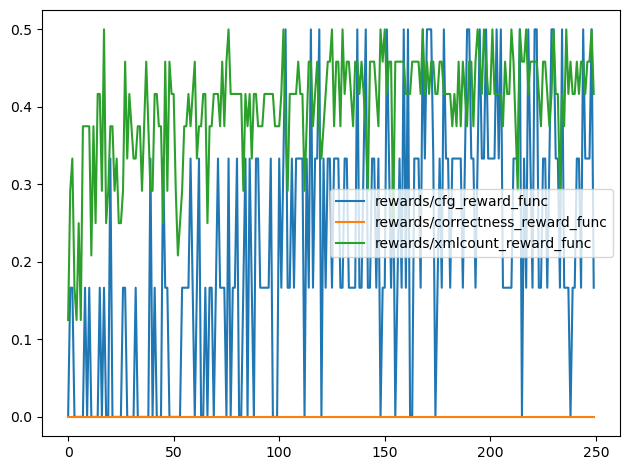

In [47]:
df_history.plot(
    y=['rewards/cfg_reward_func', 'rewards/correctness_reward_func', 'rewards/xmlcount_reward_func'], 
    use_index=True
)
plt.tight_layout()

## Neural transduction

## Neurosymbolic search

The model makes a proposal for SCM or MHMC